In [22]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns

from lib.model import FNO1d
from lib.utils import relative_l2_error, calculate_errors
from lib.dataset import PDEDatasetAll2All

In [23]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [24]:
torch.manual_seed(0)
np.random.seed(0)

In [25]:
DEVICE = "cpu"

In [26]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True,  map_location=torch.device('cpu')))

<All keys matched successfully>

In [27]:
time_pairs = [(0, 4)]
dataset_ood_same_eps = PDEDatasetAll2All(
    "data/OOD_IC_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
)

errors_same_eps, ood_relative_l2_t1 = calculate_errors(fno, dataset_ood_same_eps)

print(
    rf"OOD (same epsilon) relative L2 error (u_0 -> u(t=1.0)): {ood_relative_l2_t1:.4f}"
)

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

OOD (same epsilon) relative L2 error (u_0 -> u(t=1.0)): 0.0150


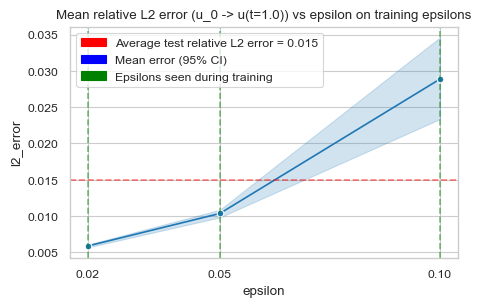

In [28]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=errors_same_eps, x="epsilon", y="l2_error", ax=ax, marker="o")
# set ticks to epsilon
ax.set_xticks(errors_same_eps["epsilon"].unique())

plt.axhline(y=ood_relative_l2_t1, color="r", linestyle="--", alpha=0.5)

# add vertical lines at epsilons seen in the training data [0.1, 0.05, 0.02]
epsilons = [0.1, 0.05, 0.02]
for epsilon in epsilons:
    plt.axvline(x=epsilon, color="g", linestyle="--", alpha=0.5, label=f"epsilon = {epsilon} seen during training")

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Average test relative L2 error = {ood_relative_l2_t1:.3f}"),
        Patch(facecolor="b", edgecolor="b", label="Mean error (95% CI)"),
        Patch(facecolor="g", edgecolor="g", label="Epsilons seen during training"),
    ]
)

plt.title("Mean relative L2 error (u_0 -> u(t=1.0)) vs epsilon on training epsilons")
plt.savefig("figures/ood_same_eps.png", dpi=300)
plt.show()

In [29]:
time_pairs = [(0, 4)]
dataset_ood = PDEDatasetAll2All(
    "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
)

errors, ood_relative_l2_t1 = calculate_errors(fno, dataset_ood)

print(rf"OOD relative L2 error (u_0 -> u(t=1.0)): {ood_relative_l2_t1:.4f}")

100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

OOD relative L2 error (u_0 -> u(t=1.0)): 0.1605


In [30]:
errors

,dt,l2_error,epsilon
0,0.035,0.033423,0.035
1,0.005,0.184824,0.005
2,0.035,0.067381,0.035
3,0.035,0.201306,0.035
4,0.005,0.184824,0.005
...,...,...,...
495,0.150,0.144920,0.150
496,0.035,0.033423,0.035
497,0.200,0.012074,0.200
498,0.075,0.311911,0.075


In [31]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
    )
)

errors, ood_relative_l2_tall = calculate_errors(fno, dataset)
print(rf"OOD relative L2 error (all delta t): {ood_relative_l2_tall:.4f}")

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:13<00:00,  2.31it/s]

OOD relative L2 error (all delta t): 0.2020


In [32]:
df = errors.sort_values("dt")
df

,dt,l2_error,epsilon
999,0.00125,0.130456,0.005
1003,0.00125,0.299714,0.005
1035,0.00125,0.185277,0.005
1037,0.00125,0.130456,0.005
1039,0.00125,0.185277,0.005
...,...,...,...
1836,0.20000,0.012074,0.200
183,0.20000,0.012074,0.200
1240,0.20000,0.339493,0.200
369,0.20000,0.012074,0.200


In [33]:
# calculate mean error for each dt
mean_error = df.groupby(pd.cut(df["dt"], bins=20), observed=True)["l2_error"].mean().reset_index()
mean_error["dt"] = mean_error["dt"].apply(lambda x: f"{x.mid:.3f}")
mean_error

,dt,l2_error
0,0.006,0.181567
1,0.016,0.077323
2,0.026,0.124530
3,0.036,0.168488
4,0.046,0.748155
5,0.056,0.078237
6,0.076,0.231061
7,0.096,0.350175
8,0.116,0.129129
9,0.145,0.172632


<Axes: xlabel='dt', ylabel='l2_error'>

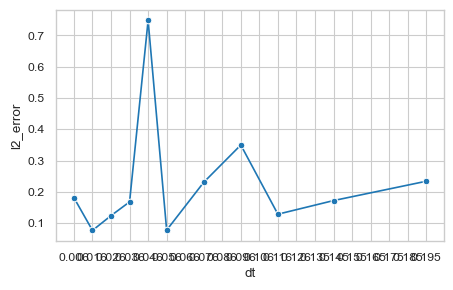

In [34]:
# plot the error
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=mean_error, x="dt", y="l2_error", ax=ax, marker="o")

In [35]:
time_pairs = [(0, 4)]
dataset_ood = PDEDatasetAll2All(
    "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
)

errors_t1, ood_relative_l2_t1 = calculate_errors(fno, dataset_ood)

print(rf"OOD relative L2 error (u_0 -> u(t=1.0)): {ood_relative_l2_t1:.4f}")

100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

OOD relative L2 error (u_0 -> u(t=1.0)): 0.1605


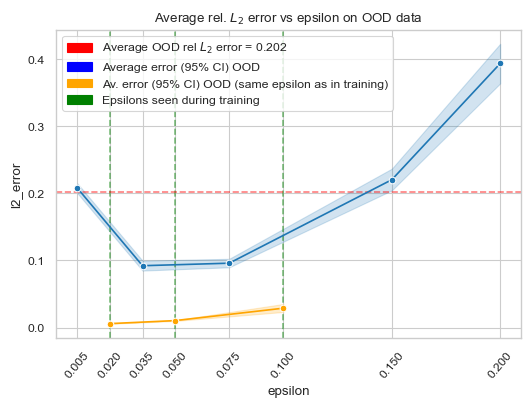

In [36]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(6, 4))
# add vertical lines at epsilons seen in the training data [0.1, 0.05, 0.02]
epsilons = [0.1, 0.05, 0.02]
for epsilon in epsilons:
    plt.axvline(x=epsilon, color="g", linestyle="--", alpha=0.5, label=f"epsilon = {epsilon} seen during training")
    
plt.axhline(y=ood_relative_l2_tall, color="r", linestyle="--", alpha=0.5)

sns.lineplot(data=df, x="epsilon", y="l2_error", ax=ax, marker="o")
sns.lineplot(data=errors_same_eps, x="epsilon", y="l2_error", ax=ax, marker="o", color="orange")
# set ticks to epsilon
ax.set_xticks(df["epsilon"].unique().tolist() + errors_same_eps["epsilon"].unique().tolist())

# set x ticks vertical
plt.xticks(rotation=50)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=rf"Average OOD rel $L_2$ error = {ood_relative_l2_tall:.3f}"),
        Patch(facecolor="b", edgecolor="b", label="Average error (95% CI) OOD"),
        Patch(facecolor="orange", edgecolor="orange", label="Av. error (95% CI) OOD (same epsilon as in training)"),
        Patch(facecolor="g", edgecolor="g", label="Epsilons seen during training"),
    ]
)
plt.title(r"Average rel. $L_2$ error vs epsilon on OOD data")
plt.savefig("figures/ac_ood_l2_vs_eps.png", dpi=300, bbox_inches="tight")
plt.show()

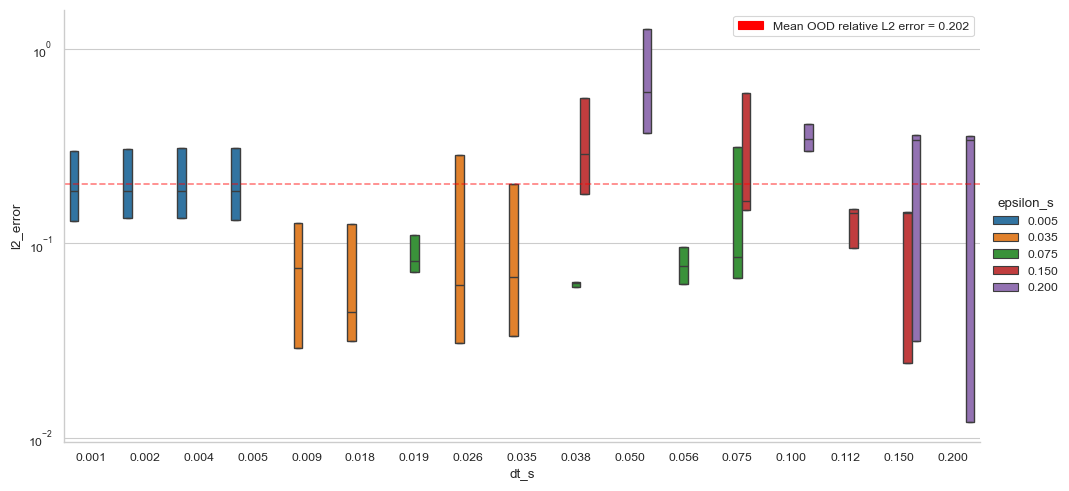

In [37]:
df["epsilon_s"] = df["epsilon"].apply(lambda x: f"{x:.3f}")
df["dt_s"] = df["dt"].apply(lambda x: f"{x:.3f}")

sns.catplot(
    data=df,
    x="dt_s",
    y="l2_error",
    log_scale=True,
    hue="epsilon_s",
    height=5,
    aspect=2,
    kind="box",
)
# draw a horizontal line at the OOD relative L2 error
plt.axhline(y=ood_relative_l2_tall, color="r", linestyle="--", label="OOD relative L2 error", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Mean OOD relative L2 error = {ood_relative_l2_tall:.3f}"),
    ]
)


In [38]:
time_pairs = [(0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
    )
)

errors, ood_relative_l2 = calculate_errors(fno, dataset)
print(rf"OOD relative L2 error (Only prediction t_0 -> t_1): {ood_relative_l2}")

100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

OOD relative L2 error (Only prediction t_0 -> t_1): 0.16053025817871094


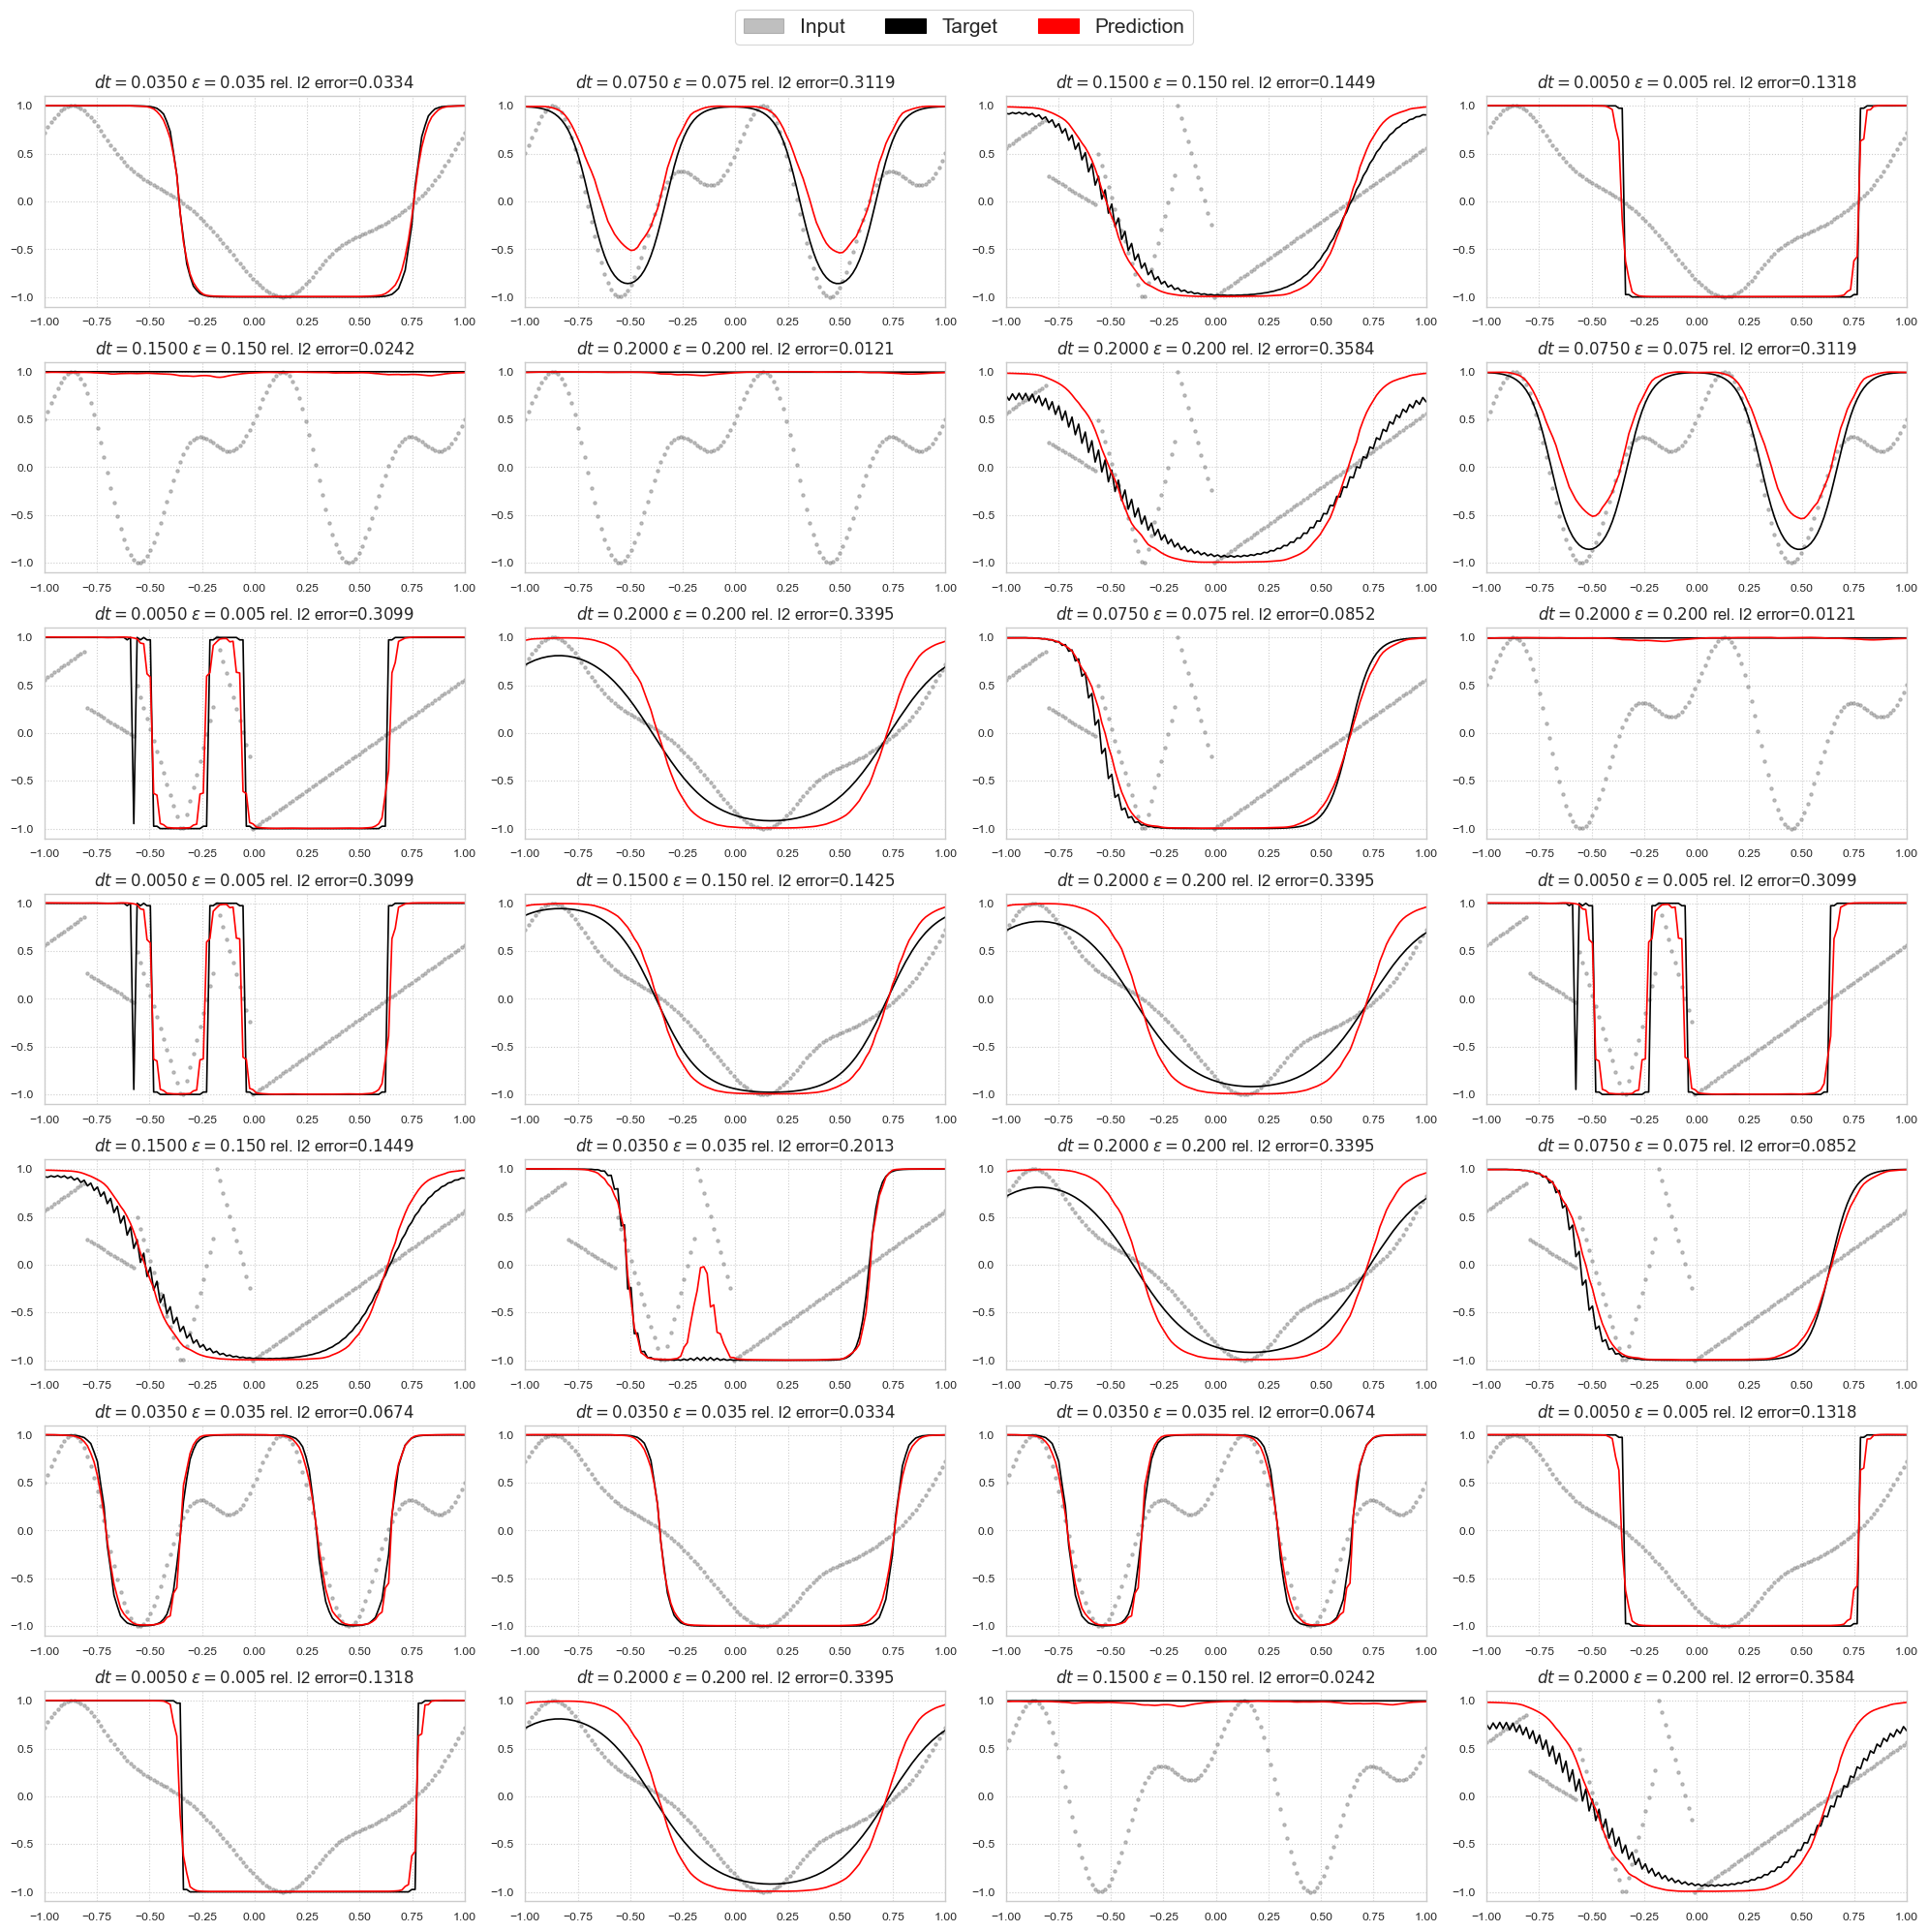

In [39]:
sampler = DataLoader(dataset, batch_size=4, shuffle=True)
fig, axs = plt.subplots(7, 4, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = eps[j].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j], dim=-1)

        ax = ax_rows[j]

        # set limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1.1, 1.1)

        ax.set_title(
            rf"$dt={time_delta[j].item():.4f}$ $\epsilon={epsilon:.3f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.scatter(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.5,
            color="gray",
            marker=".",
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = [l1, l2, l3]

labels = [l1.get_label(), l2[0].get_label(), l3[0].get_label()]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    try:
        colour = lines[group_idx][0].get_color()
        opac = lines[group_idx][0].get_alpha()
    except TypeError:
        colour = lines[group_idx].get_facecolor()
        opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("figures/ac_ood_examples.png", dpi=300)
plt.show()